## Exploring Rossmann Drug Store Sales Data

In [1]:
import pandas as pd

data = pd.read_csv('../../assets/datasets/rossmann.csv', skipinitialspace=True, low_memory=False)

Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [2]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

In [3]:
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-31,2,5,6064,625,1,1,0,1,2015,7
2015-07-31,3,5,8314,821,1,1,0,1,2015,7
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7
2015-07-31,5,5,4822,559,1,1,0,1,2015,7


In [42]:
store1_data = data[data.Store == 1]

### Data Exploration and MINEing

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days.  On state holidays, the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

In [43]:
data.Store.unique()

array([   1,    2,    3, ..., 1113, 1114, 1115])

In [44]:
store1_data.Store.unique()

array([1])

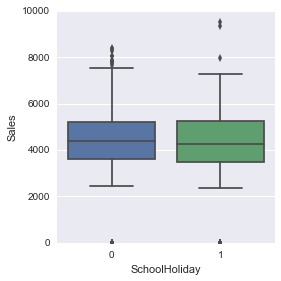

In [45]:
import seaborn as sb
%matplotlib inline

sb.factorplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Check: See if there is a difference affecting sales on promotion days.

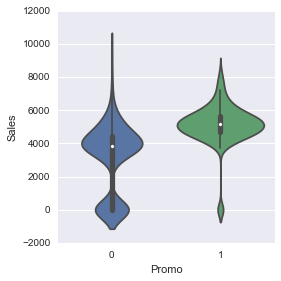

In [46]:
sb.factorplot(
    x='Promo',
    y='Sales',
    data=store1_data, 
    kind='violin'
)

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

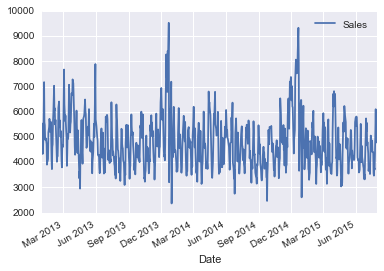

In [47]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data[['Sales']].plot()

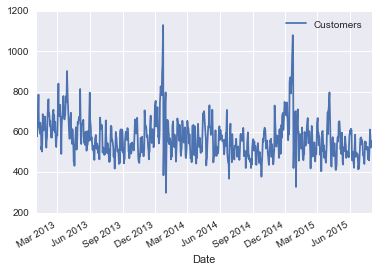

In [48]:
store1_open_data[['Customers']].plot()

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

### Data REFINING Using Time Series Statistics

### Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function:

`autocorr` takes one argument, the `lag` which is how many prio data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it. Setting `lag` to 10 computes the correlation between every point and the point 10 days earlier.

In [49]:
data['Sales'].resample('D', how='mean').autocorr(lag=1)

/Users/michaelmainzer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


-0.025858276006383574

### Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  What were the mean and median sales for each month and year?

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

In [50]:
data[['Sales']].resample('M', how=['median', 'mean']).head()

/Users/michaelmainzer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  if __name__ == '__main__':


Sales             
            median         mean
Date                           
2013-01-31  5194.0  5211.555578
2013-02-28  5421.5  5494.371397
2013-03-31  5844.0  5820.349168
2013-04-30  5464.0  5483.749836
2013-05-31  5585.0  5364.127383

While identifying the monthly averages is useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps with a few days surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

In [51]:
# Resample to have the daily average over all stores
daily_store_sales = data[['Sales']].resample('D', how='sum')

pd.rolling_mean(daily_store_sales, window=3, center=True,).head()

/Users/michaelmainzer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  from ipykernel import kernelapp as app
/Users/michaelmainzer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=3,center=True).mean()


,Sales
Date,
2013-01-01,NaN
2013-01-02,4.464961e+06
2013-01-03,6.645534e+06
2013-01-04,6.312789e+06
2013-01-05,4.244817e+06


`rolling_mean` (as well as `rolling_median`) takes these important parameters:
    - the first is the series to aggregate
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

/Users/michaelmainzer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100,center=True).mean()
  if __name__ == '__main__':


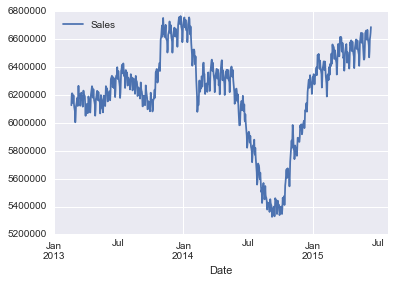

In [52]:
pd.rolling_mean(daily_store_sales, window=100, center=True).plot()

### Pandas Window functions
Pandas `rolling_mean` and `rolling_median` are only two examples of Pandas window function capabilities. Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling_mean` and `rolling_median`, there are `rolling_sum`, `rolling_min`, `rolling_max`... and many more.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many rows prior to use for the difference.


In [53]:
data['Sales'].diff(periods=1).head()

Date
2015-07-31       NaN
2015-07-31     801.0
2015-07-31    2250.0
2015-07-31    5681.0
2015-07-31   -9173.0
Name: Sales, dtype: float64

### Pandas expanding functions

In addition to the set of `rolling_*` functions, Pandas also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, use all values up until that time.

In [54]:
# computes the average sales, from the first date _until_ the date specified.
pd.expanding_mean(daily_store_sales).head()

/Users/michaelmainzer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.expanding_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.expanding(min_periods=1).mean()
  from ipykernel import kernelapp as app


,Sales
Date,
2013-01-01,9.723500e+04
2013-01-02,3.523532e+06
2013-01-03,4.464961e+06
2013-01-04,5.008460e+06
2013-01-05,5.197086e+06


## Exercises

> Plot the distribution of sales by month and compare the effect of promotions

In [55]:
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


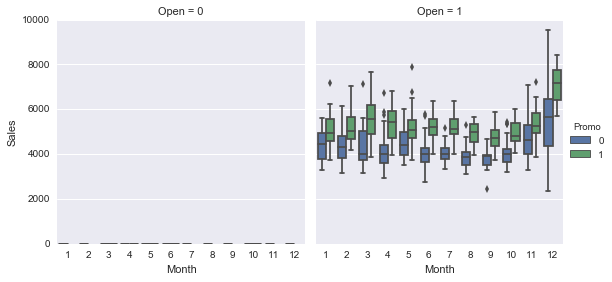

In [56]:

sb.factorplot(
    x='Month',
    y='Sales',
    data=store1_data, 
    kind='box',
    hue='Promo',
    col='Open'
)

> Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

In [60]:
x = data[['Sales','Open']].resample('D', how='mean')
print 'Daily',x.Sales.autocorr(lag=1)
print 'Weekly',x.Sales.autocorr(lag=7)
print 'Monthly',x.Sales.autocorr(lag=30)
print 'Annually',x.Sales.autocorr(lag=365)

Daily -0.0258582760064
Weekly 0.557489358874
Monthly -0.129842458225
Annually 0.0202385294483


/Users/michaelmainzer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


> Plot the 15 day rolling mean of customers in the stores

/Users/michaelmainzer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=15,center=True).mean()
  if __name__ == '__main__':


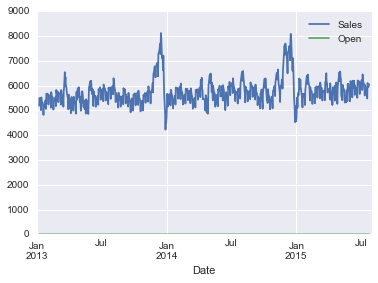

In [63]:
pd.rolling_mean(x, window=15, center=True).plot()

> Identify the date with largest drop in sales from the same date in the previous month

In [64]:
x['diff'] = x.Sales.diff(periods=30)

In [67]:
x.sort_values(by='diff').tail(50)

,Sales,Open,diff
Date,,,
2014-04-29,8481.730942,1.000000,8296.040359
2014-06-03,8608.537220,0.997309,8404.495964
2015-06-16,8642.822422,0.999103,8413.513004
2014-02-04,8656.028700,0.998206,8490.194619
2014-11-04,8750.039572,1.000000,8508.546524
2014-07-01,8812.887701,0.997861,8575.515503
2015-06-02,8901.518386,1.000000,8678.014350
2013-07-30,9026.470852,0.999103,8800.295964
2014-01-07,9378.414350,1.000000,9207.898655


> Compute the total sales up until Dec. 2014

In [69]:
pd.expanding_sum(x)['2014-11'].head()

/Users/michaelmainzer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.expanding_sum is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.expanding(min_periods=1).sum()
  if __name__ == '__main__':


,Sales,Open,diff
Date,,,
2014-11-01,3.803335e+06,557.348907,7225.110855
2014-11-02,3.803564e+06,557.367089,7124.311924
2014-11-03,3.814210e+06,558.367089,10897.263796
2014-11-04,3.822960e+06,559.367089,19405.810320
2014-11-05,3.830974e+06,560.367089,17763.422085


> When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling_mean` and `diff`